# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

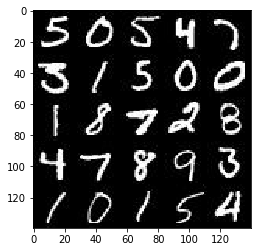

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

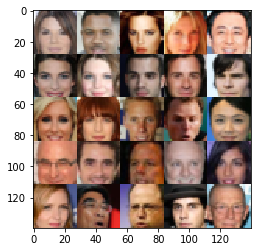

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None)
    return real_input_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    
    # input 28*28*3
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        dropout1 = tf.nn.dropout(relu1, 0.9)
        # 14x14x64
        
        x2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropout2 = tf.nn.dropout(relu2, 0.9)
        # 7x7x128
        
        x3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dropout3 = tf.nn.dropout(relu3, 0.9)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(dropout3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.sigmoid(logits)
        
        
#         dense_output = tf.layers.dense(images, 32, activation=None); #28*28*32
#         leaky_relu_layer_ouput = tf.maximum(alpha * dense_output, dense_output)
        
#         conv1_output = tf.layers.conv2d(leaky_relu_layer_ouput, 64, 3, 2, 'same') #stride=2 --> 14*14*64
#         leaky_relu_layer_ouput2 = tf.maximum(alpha * conv1_output, conv1_output)
        
#         conv2_output = tf.layers.conv2d(leaky_relu_layer_ouput2, 128, 3, 2, 'same') #stride=2 --> 7*7*128
#         leaky_relu_layer_ouput3 = tf.maximum(alpha * conv2_output, conv2_output)

#         flat_layer = tf.reshape(leaky_relu_layer_ouput3, (-1, 7*7*128))

#         logits = tf.layers.dense(flat_layer, 1, activation=None)
#         output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    # reshape
    with tf.variable_scope('generator', reuse=not is_train):
        
        dense_output = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.contrib.layers.xavier_initializer()); 
        dense_output = tf.reshape(dense_output, (-1, 7, 7, 512))
        dense_output = tf.layers.batch_normalization(dense_output, training=is_train)
        dense_output = tf.maximum(alpha * dense_output, dense_output)
        
        conv1_output = tf.layers.conv2d_transpose(dense_output, 256, 5, 1, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer()) # 7*7*256
        conv1_output = tf.layers.batch_normalization(conv1_output, training=is_train)
        conv1_output = tf.maximum(alpha * conv1_output, conv1_output)
        
        conv2_output = tf.layers.conv2d_transpose(conv1_output, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer()) #stride=2 --> 14*14*128
        conv2_output = tf.layers.batch_normalization(conv2_output, training=is_train)
        conv2_output = tf.maximum(alpha * conv2_output, conv2_output)
        
        conv3_output = tf.layers.conv2d_transpose(conv2_output, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer()) #stride=2 --> 28*28*64
        conv3_output = tf.layers.batch_normalization(conv3_output, training=is_train)
        conv3_output = tf.maximum(alpha * conv3_output, conv3_output)
        
        conv3_output_logits = tf.layers.conv2d_transpose(conv3_output, out_channel_dim, 5, 1, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer()) #stride=1 --> 28*28*out_channel_dim
        
        
        output = tf.tanh(conv3_output_logits)

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
        
    # Build the model
    g_model = generator(input_z, out_channel_dim) # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                    labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                    labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                    labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainable_variables, split into G and D parts
    trainable_vars = tf.trainable_variables()
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    discriminator_loss, generator_loss = model_loss(input_real, input_z, data_shape[3])
    discriminator_opt, generator_opt = model_opt(discriminator_loss, generator_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                step +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(discriminator_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(generator_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if step % 10 == 0:
                    train_loss_d = discriminator_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = generator_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if step % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.4010... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 1.2425
Epoch 1/2... Discriminator Loss: 1.8957... Generator Loss: 2.0038
Epoch 1/2... Discriminator Loss: 1.7983... Generator Loss: 1.7912
Epoch 1/2... Discriminator Loss: 1.5884... Generator Loss: 1.4851
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 1.0844
Epoch 1/2... Discriminator Loss: 1.7300... Generator Loss: 1.9021
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 1.6321... Generator Loss: 0.4005


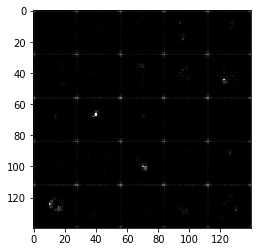

Epoch 1/2... Discriminator Loss: 1.6435... Generator Loss: 0.4582
Epoch 1/2... Discriminator Loss: 1.6584... Generator Loss: 0.3909
Epoch 1/2... Discriminator Loss: 1.8997... Generator Loss: 0.2731
Epoch 1/2... Discriminator Loss: 1.7257... Generator Loss: 0.3911
Epoch 1/2... Discriminator Loss: 1.8135... Generator Loss: 0.3465
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 1.2025
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 1.2156
Epoch 1/2... Discriminator Loss: 1.5208... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.6980


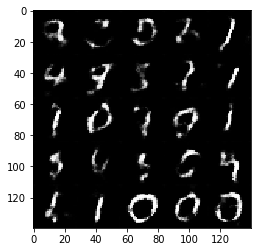

Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.8060
Epoch 1/2... Discriminator Loss: 1.5865... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 0.6115
Epoch 1/2... Discriminator Loss: 1.5527... Generator Loss: 0.4439
Epoch 1/2... Discriminator Loss: 1.5523... Generator Loss: 0.9431
Epoch 1/2... Discriminator Loss: 1.4933... Generator Loss: 0.5296
Epoch 1/2... Discriminator Loss: 1.6347... Generator Loss: 0.4272
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 1.2927


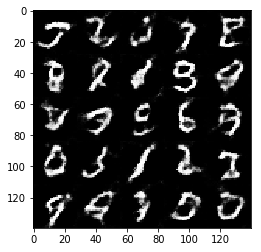

Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 1.1142
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.9371
Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.8207
Epoch 1/2... Discriminator Loss: 1.5779... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 1.6871... Generator Loss: 1.6672
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 1.0947


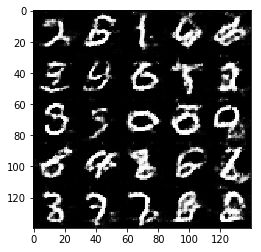

Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.9135
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 0.5474
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.6752
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.8235
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5983
Epoch 1/2... Discriminator Loss: 1.3146... Generator Loss: 0.6779
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.4472
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 1.2974
Epoch 1/2... Discriminator Loss: 1.7047... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 1.2637


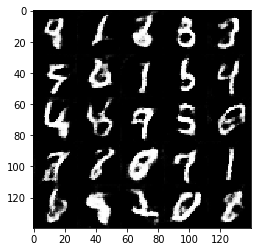

Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 1.6445
Epoch 1/2... Discriminator Loss: 1.6268... Generator Loss: 0.4366
Epoch 1/2... Discriminator Loss: 1.3501... Generator Loss: 1.3180
Epoch 1/2... Discriminator Loss: 1.2455... Generator Loss: 0.8177
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 1.7409
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 1.0423
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 0.4006
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.4862


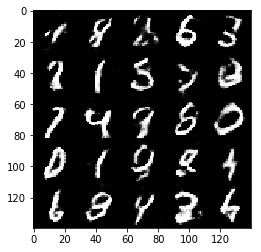

Epoch 1/2... Discriminator Loss: 1.6602... Generator Loss: 0.3304
Epoch 1/2... Discriminator Loss: 1.2374... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.6061... Generator Loss: 0.3818
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.5008
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 1.1758
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 1.2173
Epoch 1/2... Discriminator Loss: 1.7308... Generator Loss: 0.3879
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.8157
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 1.2473


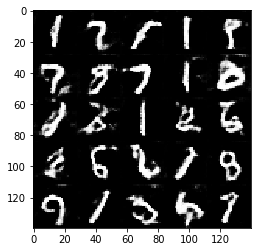

Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.7823
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 1.4940... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 1.3313... Generator Loss: 1.8925
Epoch 1/2... Discriminator Loss: 1.5772... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.2600
Epoch 1/2... Discriminator Loss: 1.0494... Generator Loss: 1.3836
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 2.2166


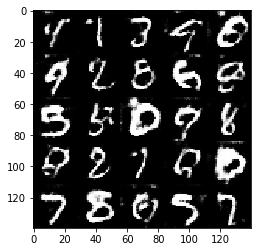

Epoch 1/2... Discriminator Loss: 1.8021... Generator Loss: 0.3002
Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.9551
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.6525
Epoch 1/2... Discriminator Loss: 1.5034... Generator Loss: 2.1447
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 1.2419... Generator Loss: 0.8681
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.5381
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.8256
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.8636


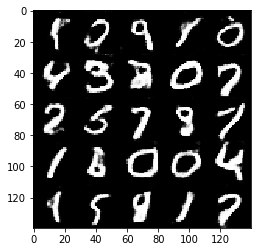

Epoch 1/2... Discriminator Loss: 1.6518... Generator Loss: 0.4093
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.6735
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.0323
Epoch 1/2... Discriminator Loss: 1.1779... Generator Loss: 0.8992
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 1.4835
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.6165
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 1.0749... Generator Loss: 1.4599


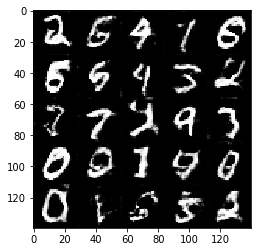

Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.8748
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 1.6882
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 0.5829
Epoch 1/2... Discriminator Loss: 1.5698... Generator Loss: 0.4342
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 1.5213
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 1.2512
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.9108
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.7054
Epoch 1/2... Discriminator Loss: 1.2089... Generator Loss: 2.2512


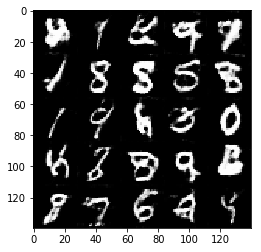

Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.2484
Epoch 1/2... Discriminator Loss: 1.1909... Generator Loss: 0.8867
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.9049
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 1.3045
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 2.3023
Epoch 1/2... Discriminator Loss: 1.5066... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 1.6539... Generator Loss: 0.4359
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 1.4161
Epoch 1/2... Discriminator Loss: 1.2712... Generator Loss: 0.9682


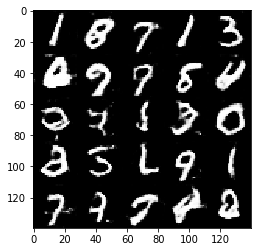

Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.5289... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 1.1494... Generator Loss: 1.3062
Epoch 1/2... Discriminator Loss: 1.6003... Generator Loss: 0.4865
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 1.4544
Epoch 1/2... Discriminator Loss: 1.0597... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 1.2924
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.7433


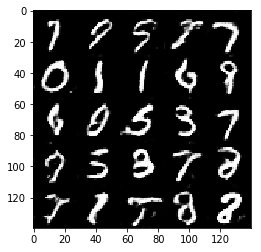

Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 1.6652
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 1.1278... Generator Loss: 0.8591
Epoch 1/2... Discriminator Loss: 1.7674... Generator Loss: 0.3363
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.5356... Generator Loss: 0.5265
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 1.5280
Epoch 1/2... Discriminator Loss: 1.5537... Generator Loss: 0.4084
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.5232
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.6350


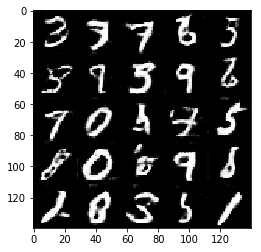

Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 1.2943
Epoch 1/2... Discriminator Loss: 1.1478... Generator Loss: 0.8645
Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.1476... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 1.6224... Generator Loss: 0.4335
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 1.4549
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 1.2190
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 1.6825... Generator Loss: 0.4080


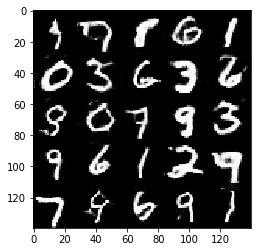

Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.9077
Epoch 1/2... Discriminator Loss: 1.6268... Generator Loss: 0.4352
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.1454
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 1.0204
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.6498
Epoch 1/2... Discriminator Loss: 1.1633... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 1.5938
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.5583


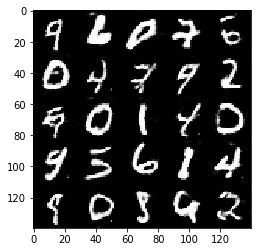

Epoch 1/2... Discriminator Loss: 1.6383... Generator Loss: 0.4184
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.5650
Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 1.6115
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.7057
Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 1.4087
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.3305
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.4814
Epoch 1/2... Discriminator Loss: 1.2350... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 1.6583
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.9153


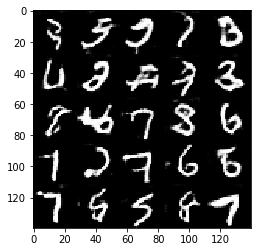

Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.9932
Epoch 1/2... Discriminator Loss: 1.1300... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 1.2653... Generator Loss: 0.7504
Epoch 1/2... Discriminator Loss: 1.1848... Generator Loss: 1.2842
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 1.2630
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 1.6494
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.6372


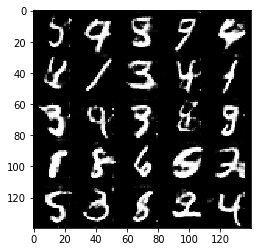

Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 1.1347
Epoch 1/2... Discriminator Loss: 1.2160... Generator Loss: 1.3445
Epoch 1/2... Discriminator Loss: 1.2813... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 0.9299... Generator Loss: 1.6437
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 2.0136
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 1.3545
Epoch 2/2... Discriminator Loss: 1.7379... Generator Loss: 0.3884
Epoch 2/2... Discriminator Loss: 1.0895... Generator Loss: 1.4452
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.9146
Epoch 2/2... Discriminator Loss: 1.5198... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.5438... Generator Loss: 0.5538
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 0.9687
Epoch 2/2... Discriminator Loss: 0.9497... Generator Loss: 0.9492
Epoch 2/2.

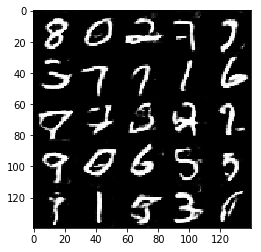

Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.9835
Epoch 2/2... Discriminator Loss: 1.5661... Generator Loss: 0.5009
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 1.1154
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 1.6119... Generator Loss: 0.4390
Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 1.0784
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 1.2273
Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 1.8952
Epoch 2/2... Discriminator Loss: 0.9180... Generator Loss: 2.0266
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 0.8703


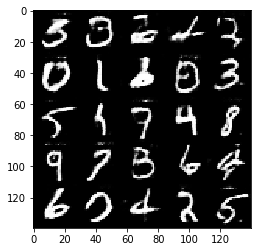

Epoch 2/2... Discriminator Loss: 1.0504... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.8713
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.9251
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.5509
Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 1.1951
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.6571
Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 1.2453
Epoch 2/2... Discriminator Loss: 1.0275... Generator Loss: 1.1575
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 0.9522


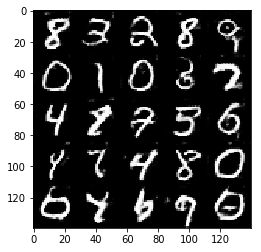

Epoch 2/2... Discriminator Loss: 1.7397... Generator Loss: 0.3696
Epoch 2/2... Discriminator Loss: 1.0001... Generator Loss: 1.5075
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 1.3277
Epoch 2/2... Discriminator Loss: 1.7693... Generator Loss: 0.4409
Epoch 2/2... Discriminator Loss: 1.3748... Generator Loss: 0.5621
Epoch 2/2... Discriminator Loss: 0.9314... Generator Loss: 1.5464
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 1.6160
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 0.9154... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 0.8513


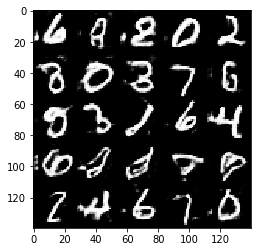

Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.8294
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 1.9420
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 0.9618
Epoch 2/2... Discriminator Loss: 0.9754... Generator Loss: 1.3733
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 1.2496
Epoch 2/2... Discriminator Loss: 1.4920... Generator Loss: 0.4760
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 1.3877... Generator Loss: 1.9168
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 0.8937
Epoch 2/2... Discriminator Loss: 1.6800... Generator Loss: 0.3459


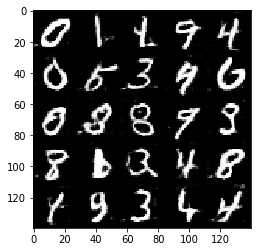

Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.5783
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.6264
Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 0.5915
Epoch 2/2... Discriminator Loss: 0.8998... Generator Loss: 1.1433
Epoch 2/2... Discriminator Loss: 1.2767... Generator Loss: 0.8301
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 1.6476
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.7363


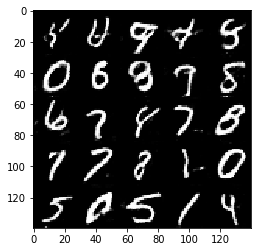

Epoch 2/2... Discriminator Loss: 1.0810... Generator Loss: 1.2126
Epoch 2/2... Discriminator Loss: 1.4898... Generator Loss: 0.4886
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 1.5836
Epoch 2/2... Discriminator Loss: 1.6192... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 1.6866... Generator Loss: 0.4089
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.5875
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.6297
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 1.1321


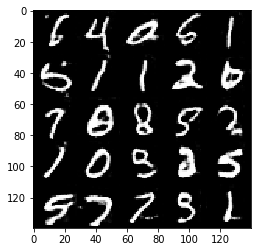

Epoch 2/2... Discriminator Loss: 1.9841... Generator Loss: 0.3460
Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.7736
Epoch 2/2... Discriminator Loss: 1.2705... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 1.1406
Epoch 2/2... Discriminator Loss: 1.2222... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.4672
Epoch 2/2... Discriminator Loss: 0.8722... Generator Loss: 1.4117
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 1.8575... Generator Loss: 0.2986
Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 1.1910


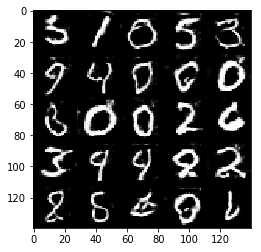

Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.6668
Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 2.0826
Epoch 2/2... Discriminator Loss: 1.8309... Generator Loss: 0.3566
Epoch 2/2... Discriminator Loss: 1.5013... Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.7049
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 1.3008
Epoch 2/2... Discriminator Loss: 1.3746... Generator Loss: 3.3470
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.4566
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 1.0662... Generator Loss: 0.8423


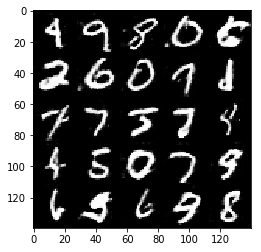

Epoch 2/2... Discriminator Loss: 1.2096... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.6203
Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.9706
Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.4098
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.7880
Epoch 2/2... Discriminator Loss: 1.4742... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.4788


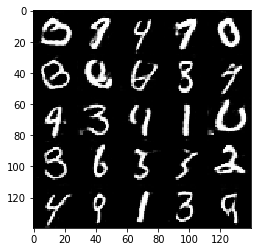

Epoch 2/2... Discriminator Loss: 1.1190... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.8347
Epoch 2/2... Discriminator Loss: 1.1216... Generator Loss: 1.1975
Epoch 2/2... Discriminator Loss: 1.0289... Generator Loss: 1.3799
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 1.6853... Generator Loss: 3.0276
Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.7975
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 1.0249... Generator Loss: 1.2088
Epoch 2/2... Discriminator Loss: 0.9414... Generator Loss: 1.6542


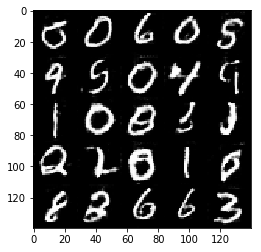

Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.0003... Generator Loss: 1.0499
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.0982
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 1.3521
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 1.9172
Epoch 2/2... Discriminator Loss: 0.9571... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 1.5932... Generator Loss: 0.3606
Epoch 2/2... Discriminator Loss: 1.5446... Generator Loss: 0.5522
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.4207


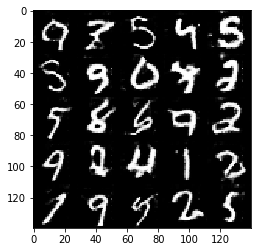

Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 0.4247
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 1.4533
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 0.9082... Generator Loss: 1.6531
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 1.2646
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.4584
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 1.2357
Epoch 2/2... Discriminator Loss: 1.6311... Generator Loss: 0.4356
Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 1.6718
Epoch 2/2... Discriminator Loss: 0.9689... Generator Loss: 1.2073


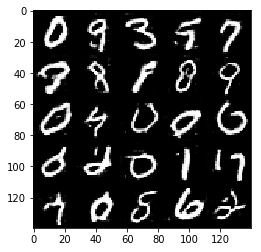

Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.8471
Epoch 2/2... Discriminator Loss: 1.2042... Generator Loss: 0.9792
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 1.0747
Epoch 2/2... Discriminator Loss: 1.8029... Generator Loss: 0.3271
Epoch 2/2... Discriminator Loss: 1.5587... Generator Loss: 0.4846
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.0371... Generator Loss: 1.4897
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.8716
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 0.9030... Generator Loss: 1.1765


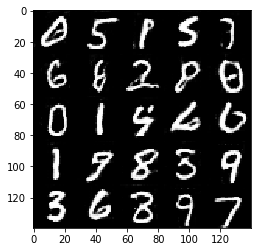

Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.5711
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.4280
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 1.1027
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.8139... Generator Loss: 0.3811
Epoch 2/2... Discriminator Loss: 1.0209... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 1.0106


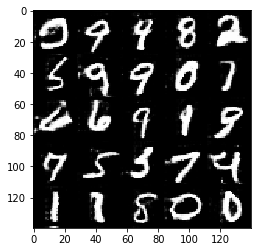

Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 1.3135
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 1.6830
Epoch 2/2... Discriminator Loss: 1.7407... Generator Loss: 0.4427
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 2.0322
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 1.3518
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 2.2183
Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 0.8267
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.6879


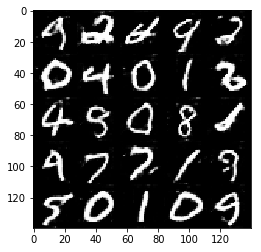

Epoch 2/2... Discriminator Loss: 1.9887... Generator Loss: 0.3237
Epoch 2/2... Discriminator Loss: 1.5543... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 0.9581
Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 1.0185
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 1.5567
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.2138
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.3059
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.4653... Generator Loss: 0.6834


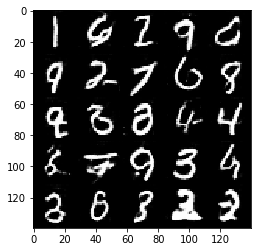

Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 1.1707
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 1.4958
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 1.8087
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 0.8334
Epoch 2/2... Discriminator Loss: 0.8465... Generator Loss: 1.4599
Epoch 2/2... Discriminator Loss: 1.1728... Generator Loss: 1.0132
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.9087
Epoch 2/2... Discriminator Loss: 1.1415... Generator Loss: 0.7756
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 1.1569


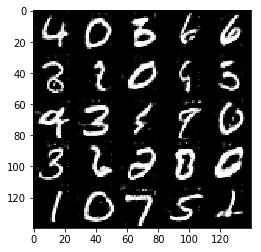

Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 0.5679
Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 0.9266... Generator Loss: 1.5308
Epoch 2/2... Discriminator Loss: 0.9091... Generator Loss: 1.3531
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 1.2734
Epoch 2/2... Discriminator Loss: 1.5033... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.4507... Generator Loss: 1.8012


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0008
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7235... Generator Loss: 15.4370
Epoch 1/1... Discriminator Loss: 3.9674... Generator Loss: 0.0527
Epoch 1/1... Discriminator Loss: 3.4363... Generator Loss: 9.7578
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 2.0158... Generator Loss: 0.3051
Epoch 1/1... Discriminator Loss: 2.2289... Generator Loss: 0.2268
Epoch 1/1... Discriminator Loss: 2.0495... Generator Loss: 0.3430
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.5990


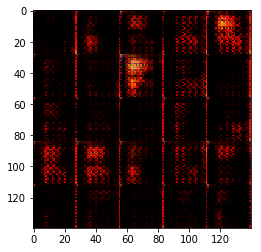

Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 2.2576... Generator Loss: 0.2036
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.5468
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.3311
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.0249


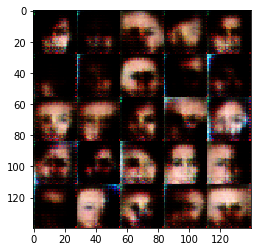

Epoch 1/1... Discriminator Loss: 2.0024... Generator Loss: 0.2861
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 1.5824... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.4080
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 2.2908
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.4729
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 2.0377... Generator Loss: 2.2452


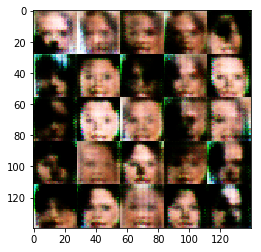

Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 1.7391
Epoch 1/1... Discriminator Loss: 2.3280... Generator Loss: 0.1563
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.5682
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.5661


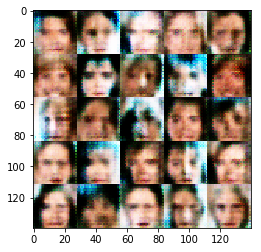

Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 1.8361... Generator Loss: 1.9211
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 2.1704... Generator Loss: 0.1982
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.7271... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7765


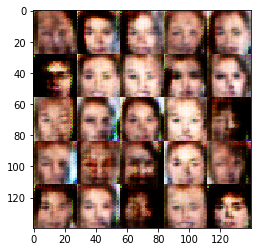

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 1.3602
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 2.1000
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.5953
Epoch 1/1... Discriminator Loss: 1.9836... Generator Loss: 1.9416


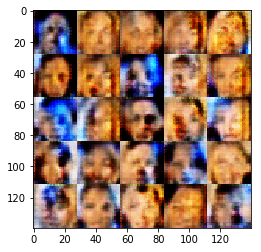

Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 1.3241
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 1.6094


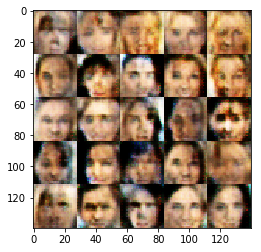

Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.7210... Generator Loss: 0.3307
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.7499


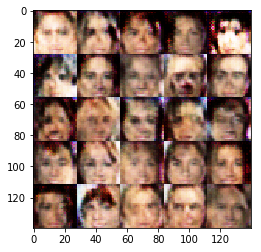

Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 2.0066... Generator Loss: 0.2785
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.0172
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9746


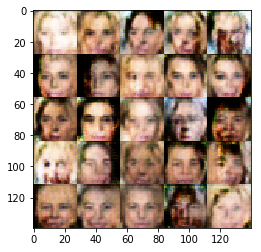

Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.8802... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 1.7515


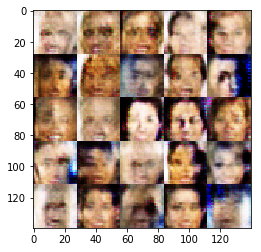

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.2426
Epoch 1/1... Discriminator Loss: 1.8208... Generator Loss: 0.3492


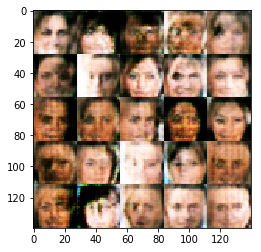

Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.6910
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 2.0823... Generator Loss: 0.2788
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 1.3554


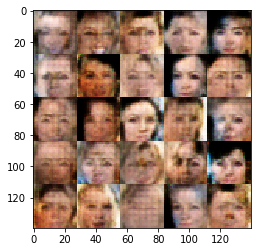

Epoch 1/1... Discriminator Loss: 1.9955... Generator Loss: 0.2765
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.8208... Generator Loss: 0.3614
Epoch 1/1... Discriminator Loss: 1.6028... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5351


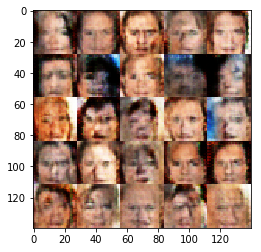

Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.6187... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.4156
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.9639... Generator Loss: 0.3212


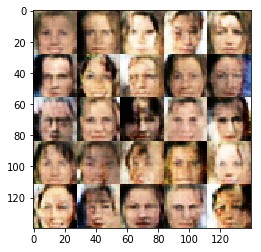

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 1.1137
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 0.8262


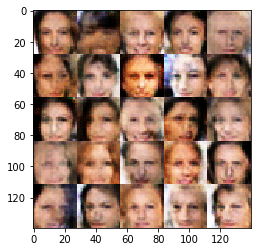

Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 1.3475


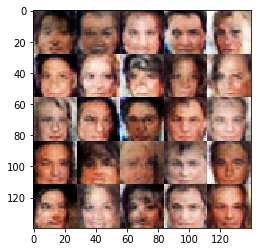

Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.6723... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.7576


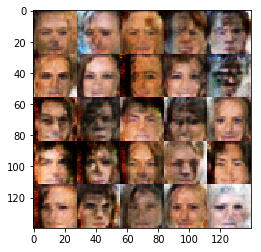

Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.4254
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.8936... Generator Loss: 1.8517
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.6882


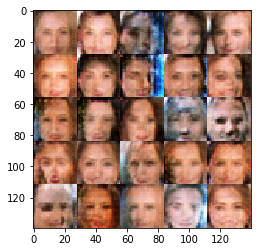

Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.8043... Generator Loss: 0.3531
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.9546


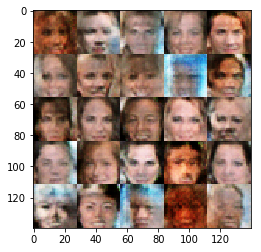

Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 1.2078
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8744


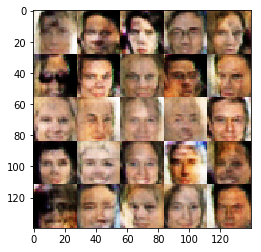

Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.7044... Generator Loss: 1.5774
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 1.1451
Epoch 1/1... Discriminator Loss: 1.9249... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.4154
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.6460


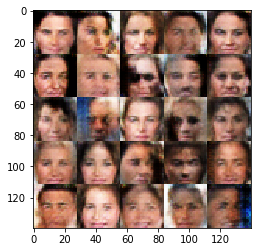

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.8580... Generator Loss: 0.3838
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.0384


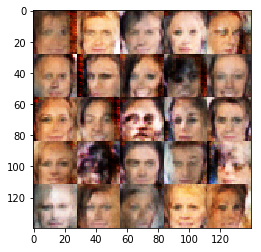

Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.9200... Generator Loss: 0.2944
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.7653... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7597


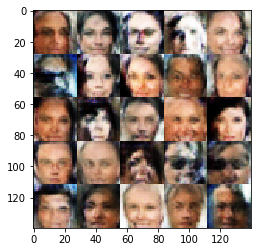

Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6588


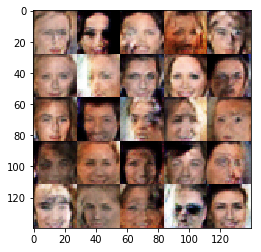

Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.7030


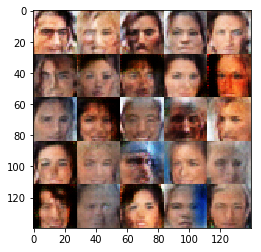

Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.6506


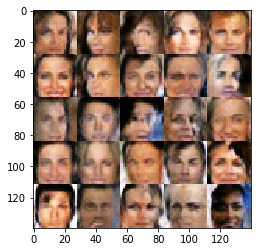

Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 0.4497
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5739
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 1.3641
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.6328... Generator Loss: 0.6111


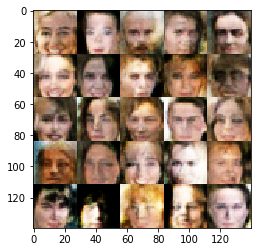

Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 1.4230
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 0.8240


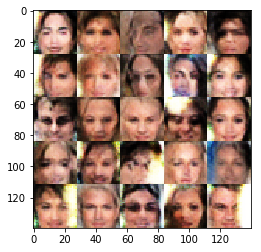

Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 1.3767
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.7399... Generator Loss: 0.3663
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.8272... Generator Loss: 0.4727
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.8450


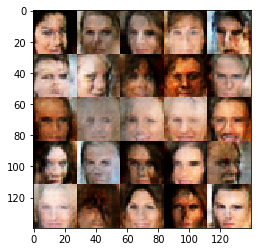

Epoch 1/1... Discriminator Loss: 1.7169... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.7277


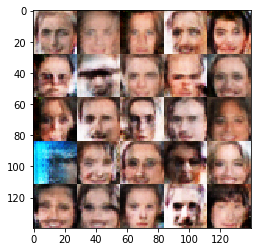

Epoch 1/1... Discriminator Loss: 1.6826... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.4162
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.7853... Generator Loss: 0.3121
Epoch 1/1... Discriminator Loss: 1.7111... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.6822


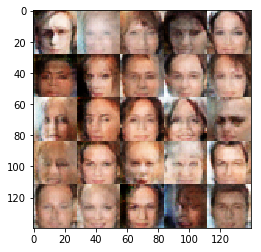

Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.6283... Generator Loss: 0.4749
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1483... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.5936


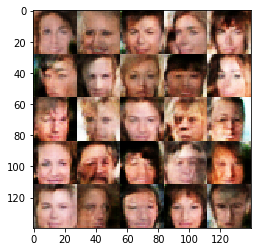

Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.5061


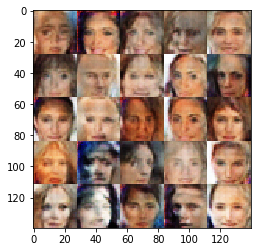

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 1.6562
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.6572... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.7181... Generator Loss: 1.3621


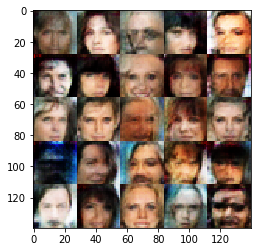

Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.6360


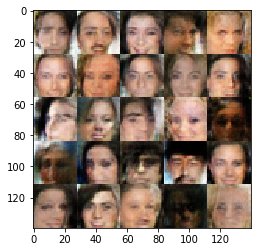

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.0929
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6951


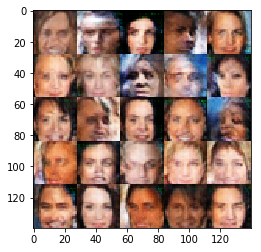

Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8032


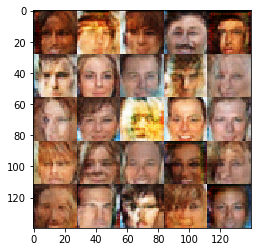

Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8906


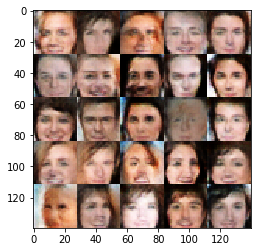

Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8426


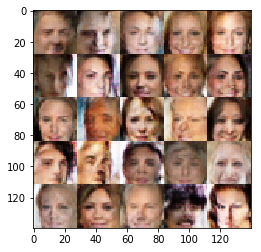

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.5498


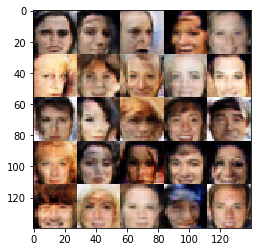

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.6897... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.7147


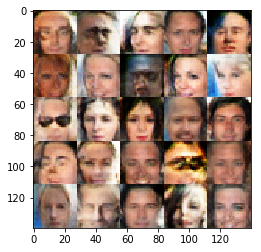

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.7953... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.7617


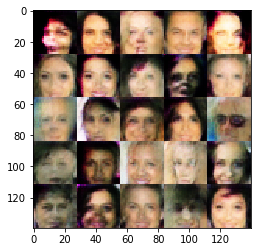

Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.9912
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 2.0125... Generator Loss: 0.2333


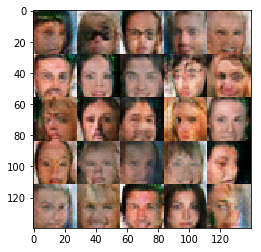

Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 1.6337... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.8794


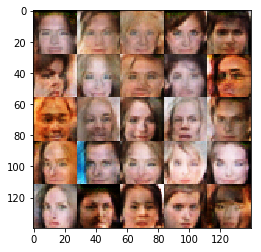

Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.7980


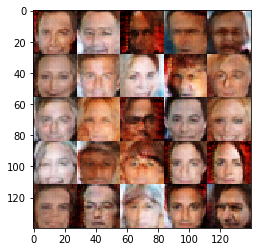

Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 1.0907
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.8586... Generator Loss: 0.3488
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.7929


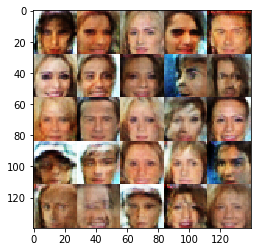

Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6869


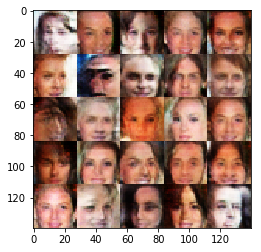

Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 1.1305


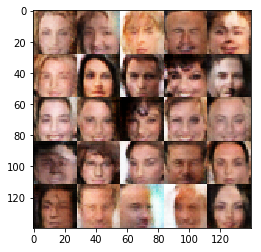

Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.9547
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5863


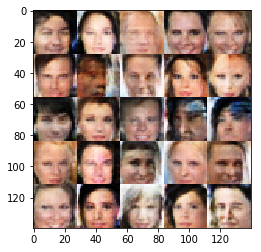

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.4201
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.8247


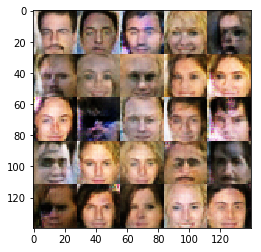

Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4678
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8306


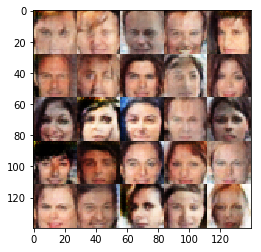

Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6125
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7611


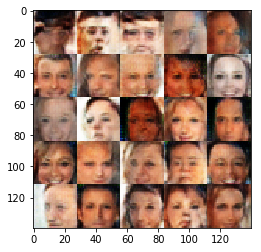

Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7550


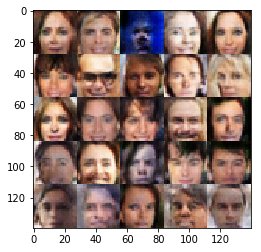

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.8096


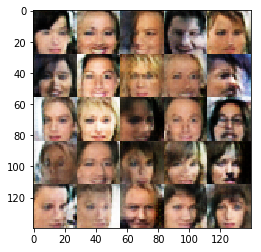

Epoch 1/1... Discriminator Loss: 1.6266... Generator Loss: 0.4331
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.5794


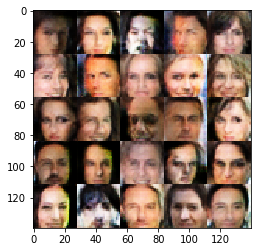

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.4587
Epoch 1/1... Discriminator Loss: 1.6902... Generator Loss: 0.3253
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.7053


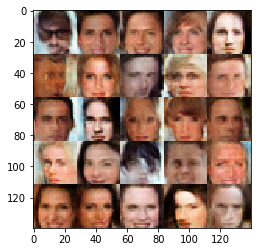

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.7715... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7298


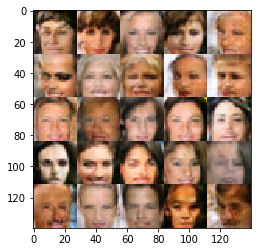

Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 0.7224


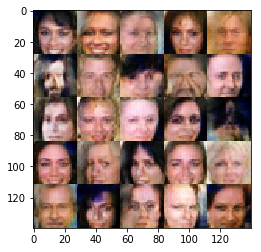

Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6405
Epoch 1/1... Discriminator Loss: 1.7158... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.5593


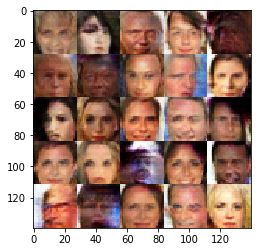

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6678


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0008
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.